In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from tqdm import tqdm

from compute_risk import *
from generate_data import *
from fixed_point_sol import *

In [2]:
import glob
import os
for method in ['ridge', 'lasso', 'logistic', 'kNN']:
    for file in glob.glob('result/ex1/{}/*.csv'.format(method)):
        os.rename(file, file.replace('_wr',''))

# Section 5.1

## Ridgeless

In [3]:
rho = 1.
SNR = 0.01
sigma = rho / np.sqrt(SNR)
lam = 0.

M_list = np.array([1, 2, 5, 10, 50])
M_str = np.append(M_list.astype(str), ['$\infty$'])

df_res = pd.DataFrame()
df_res_the = pd.DataFrame()
path_result = 'result/ex1/ridge/'
for phi in [0.1, 1.1]:
    _df = pd.read_csv(path_result+'res_phi_{:.01f}_lam_{:.01f}_SNR_{:.02f}.csv'.format(
        phi, lam, SNR))
    _df.columns = ['phi_s','seed', 'type']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist() + [r'risk-0']
    _df = pd.wide_to_long(_df, stubnames='risk', i=['phi_s', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
    _df['M'] = _df['M'].astype(int).astype(str)
    _df.loc[_df['M']=='0','M'] = '$\infty$'    
    _df = _df[_df['M'].isin(M_str)]
    _df['phi'] = phi
    df_res = pd.concat([df_res, _df], axis=0)
    
    
    phi_s_list = np.logspace(-1,1, 5000)
    phi_s_list[np.where(phi_s_list>=phi)[0][0]] = phi

    tmp = []
    for phi_s in phi_s_list:
        if phi_s<phi or phi_s==1.:
            continue
        _M_list = np.append(M_list, [np.inf])
        B, V, risk_the = comp_theoretic_risk(rho, sigma, lam, phi, phi_s, M=_M_list)
        for iM, M in enumerate(_M_list):            
            tmp.append([phi_s,
                        '{:d}'.format(int(M)) if M<np.inf else '$\infty$',
                        B[iM],V[iM],risk_the[iM]])        
    res_the = pd.DataFrame(tmp, columns=['phi_s', 'M', 'B_M', 'V_M', 'risk'])
    
    res_the['phi'] = phi
    df_res_the = pd.concat([df_res_the, res_the])

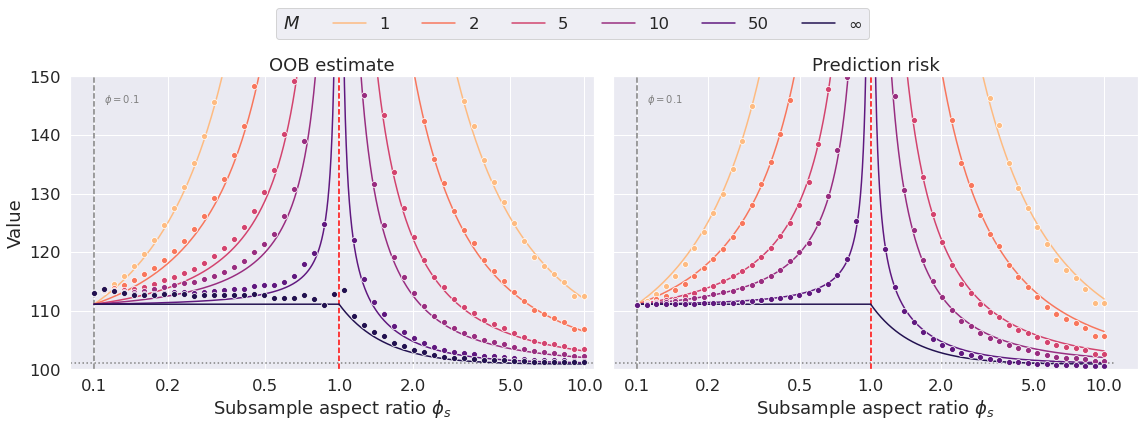

In [4]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 1*sigma**2, 1.5*sigma**2
y_text_list = [y_max * 0.97, y_max * 0.97]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 0.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    
    if phi<1:
        sns.lineplot(
            data=df_res_the[
                (df_res_the['phi']==phi)&
                (df_res_the['phi_s']<1)&
                (df_res_the['M'].isin(hue_order))], x='phi_s', y='risk',#linewidth=1,
                     hue='M', ci=None, legend=False, palette=cm, ax=axes[j])
    sns.lineplot(
        data=df_res_the[
            (df_res_the['phi']==phi)&
            (df_res_the['phi_s']>1)&
            (df_res_the['M'].isin(hue_order))], x='phi_s', y='risk',# linewidth=1,
                 hue='M', ci=None, legend='full', palette=cm, ax=axes[j])
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='', marker='o', legend=False, palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='', marker='o', legend=False, palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])

axes[0].set_xlim([0.08, 11])
# axes[1].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_ridgeless_phi_0.1.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

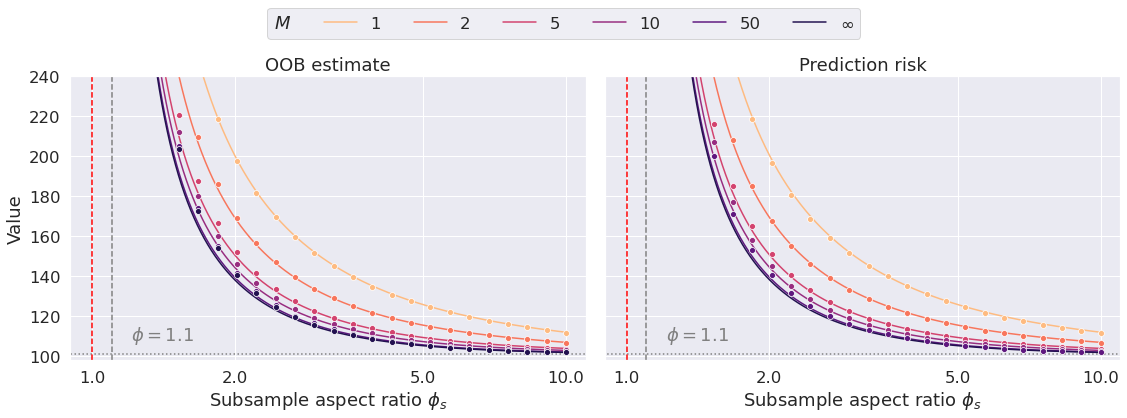

In [5]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 0.98*sigma**2, 2.4*sigma**2
y_text_list = [y_min * 1.1, y_min * 1.1]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 1.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    sns.lineplot(
        data=df_res_the[
            (df_res_the['phi']==phi)&
            (df_res_the['phi_s']>1)&
            (df_res_the['M'].isin(hue_order))], x='phi_s', y='risk',# linewidth=1,
                 hue='M', ci=None, legend='full', palette=cm, ax=axes[j])
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='', marker='o', legend=False, palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='', marker='o', legend=False, palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])


    axes[j].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_ridgeless_phi_1.1.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Ridge

In [6]:
rho = 1.
SNR = 0.01
sigma = rho / np.sqrt(SNR)
lam = 0.1

M_list = np.array([1, 2, 5, 10, 50])
M_str = np.append(M_list.astype(str), ['$\infty$'])

df_res = pd.DataFrame()
df_res_the = pd.DataFrame()
path_result = 'result/ex1/ridge/'
for phi in [0.1, 1.1]:
    _df = pd.read_csv(path_result+'res_phi_{:.01f}_lam_{:.01f}_SNR_{:.02f}.csv'.format(
        phi, lam, SNR))
    _df.columns = ['phi_s','seed', 'type']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist() + [r'risk-0']
    _df = pd.wide_to_long(_df, stubnames='risk', i=['phi_s', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
    _df['M'] = _df['M'].astype(int).astype(str)
    _df.loc[_df['M']=='0','M'] = '$\infty$'    
    _df = _df[_df['M'].isin(M_str)]
    _df['phi'] = phi
    df_res = pd.concat([df_res, _df], axis=0)
    
    
    phi_s_list = np.logspace(-1,1, 5000)
    phi_s_list[np.where(phi_s_list>=phi)[0][0]] = phi

    tmp = []
    for phi_s in phi_s_list:
        if phi_s<phi or phi_s==1.:
            continue
        _M_list = np.append(M_list, [np.inf])
        B, V, risk_the = comp_theoretic_risk(rho, sigma, lam, phi, phi_s, M=_M_list)
        for iM, M in enumerate(_M_list):            
            tmp.append([phi_s,
                        '{:d}'.format(int(M)) if M<np.inf else '$\infty$',
                        B[iM],V[iM],risk_the[iM]])        
    res_the = pd.DataFrame(tmp, columns=['phi_s', 'M', 'B_M', 'V_M', 'risk'])
    
    res_the['phi'] = phi
    df_res_the = pd.concat([df_res_the, res_the])


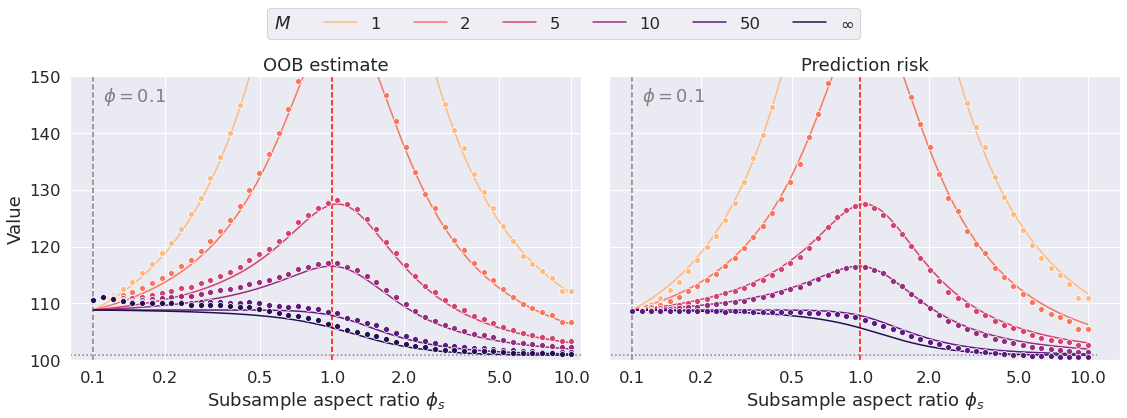

In [7]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 1*sigma**2, 1.5*sigma**2
y_text_list = [y_max * 0.97, y_max * 0.97]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 0.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    
    if phi<1:
        sns.lineplot(
            data=df_res_the[
                (df_res_the['phi']==phi)&
                (df_res_the['phi_s']<1)&
                (df_res_the['M'].isin(hue_order))], x='phi_s', y='risk',#linewidth=1,
                     hue='M', ci=None, legend=False, palette=cm, ax=axes[j])
    sns.lineplot(
        data=df_res_the[
            (df_res_the['phi']==phi)&
            (df_res_the['phi_s']>1)&
            (df_res_the['M'].isin(hue_order))], x='phi_s', y='risk',# linewidth=1,
                 hue='M', ci=None, legend='full', palette=cm, ax=axes[j])
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='', marker='o', legend=False, palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='', marker='o', legend=False, palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])

axes[0].set_xlim([0.08, 11])
# axes[1].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_ridge_{:.01f}_phi_0.1.pdf'.format(lam),
            bbox_inches='tight', pad_inches=0, dpi=300,)

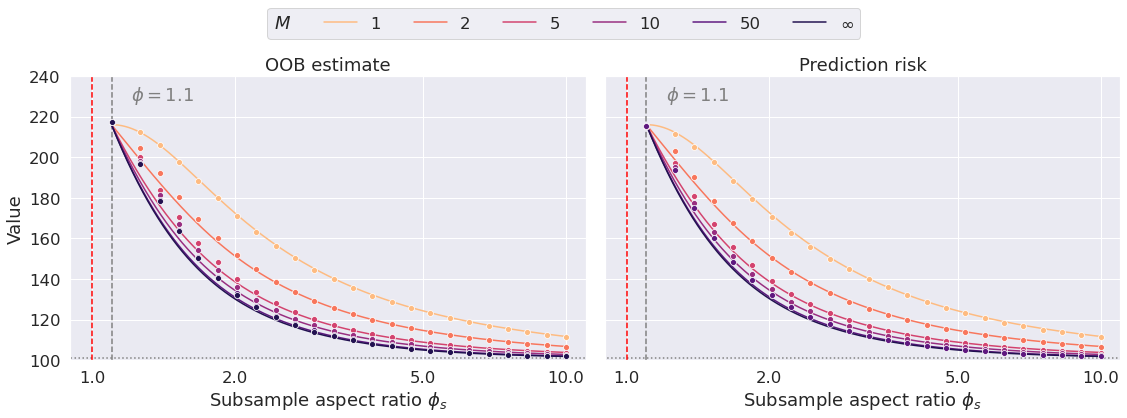

In [8]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = sigma**2, 2.4*sigma**2
y_text_list = [y_max * 0.95, y_max * 0.95]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 1.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    sns.lineplot(
        data=df_res_the[
            (df_res_the['phi']==phi)&
            (df_res_the['phi_s']>1)&
            (df_res_the['M'].isin(hue_order))], x='phi_s', y='risk',# linewidth=1,
                 hue='M', ci=None, legend='full', palette=cm, ax=axes[j])
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='', marker='o', legend=False, palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='', marker='o', legend=False, palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])


    axes[j].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_ridge_{:.01f}_phi_1.1.pdf'.format(lam),
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Lassoless

In [9]:
rho = 1.
SNR = 0.25
lam = 0.
sigma = rho / np.sqrt(SNR)

M_list = np.array([1, 2, 5, 10, 50])
M_str = np.append(M_list.astype(str), ['$\infty$'])

df_res = pd.DataFrame()
df_res_the = pd.DataFrame()
path_result = 'result/ex1/lasso/'
for phi in [0.1, 1.1]:
    _df = pd.read_csv(path_result+'res_phi_{:.01f}_lam_{:.01f}_SNR_{:.02f}.csv'.format(
        phi, lam, SNR))
    _df.columns = ['phi_s','seed', 'type']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist() + [r'risk-0']
    _df = pd.wide_to_long(_df, stubnames='risk', i=['phi_s', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
    _df['M'] = _df['M'].astype(int).astype(str)
    _df.loc[_df['M']=='0','M'] = '$\infty$'    
    _df = _df[_df['M'].isin(M_str)]
    _df['phi'] = phi
    df_res = pd.concat([df_res, _df], axis=0)

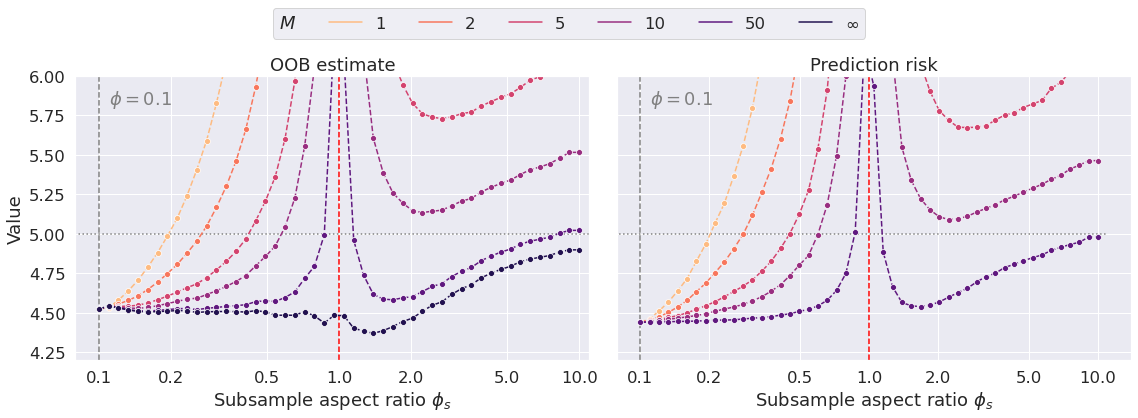

In [10]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 1.05*sigma**2, 1.5*sigma**2
y_text_list = [y_max * 0.97, y_max * 0.97]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 0.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])

axes[0].set_xlim([0.08, 11])
# axes[1].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_lassoless_phi_0.1.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

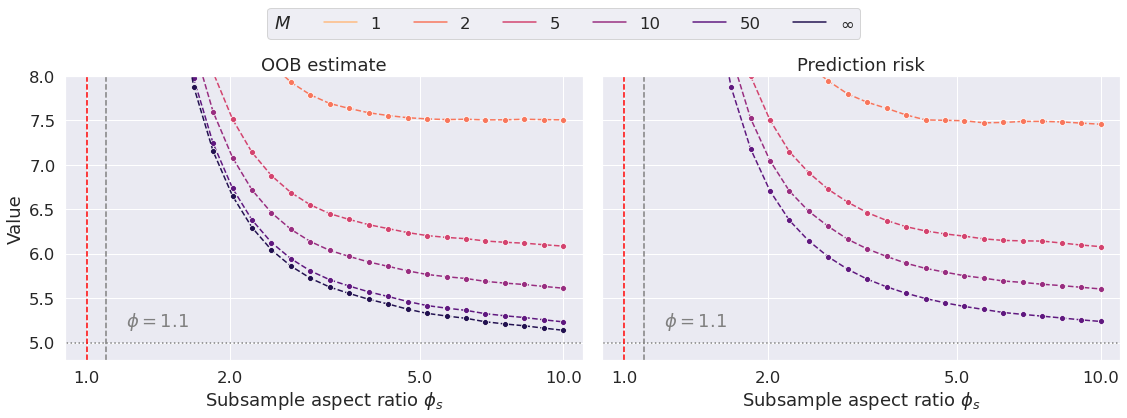

In [11]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 1.2*sigma**2, 2*sigma**2
y_text_list = [y_min * 1.08, y_min * 1.08]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 1.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    

    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])


    axes[j].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_lassoless_phi_1.1.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Lasso

In [12]:
rho = 1.
SNR = 0.25
lam = 0.1
sigma = rho / np.sqrt(SNR)

M_list = np.array([1, 2, 5, 10, 50])
M_str = np.append(M_list.astype(str), ['$\infty$'])

df_res = pd.DataFrame()
df_res_the = pd.DataFrame()
path_result = 'result/ex1/lasso/'
for phi in [0.1, 1.1]:
    _df = pd.read_csv(path_result+'res_phi_{:.01f}_lam_{:.01f}_SNR_{:.02f}.csv'.format(
        phi, lam, SNR))
    _df.columns = ['phi_s','seed', 'type']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist() + [r'risk-0']
    _df = pd.wide_to_long(_df, stubnames='risk', i=['phi_s', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
    _df['M'] = _df['M'].astype(int).astype(str)
    _df.loc[_df['M']=='0','M'] = '$\infty$'    
    _df = _df[_df['M'].isin(M_str)]
    _df['phi'] = phi
    df_res = pd.concat([df_res, _df], axis=0)

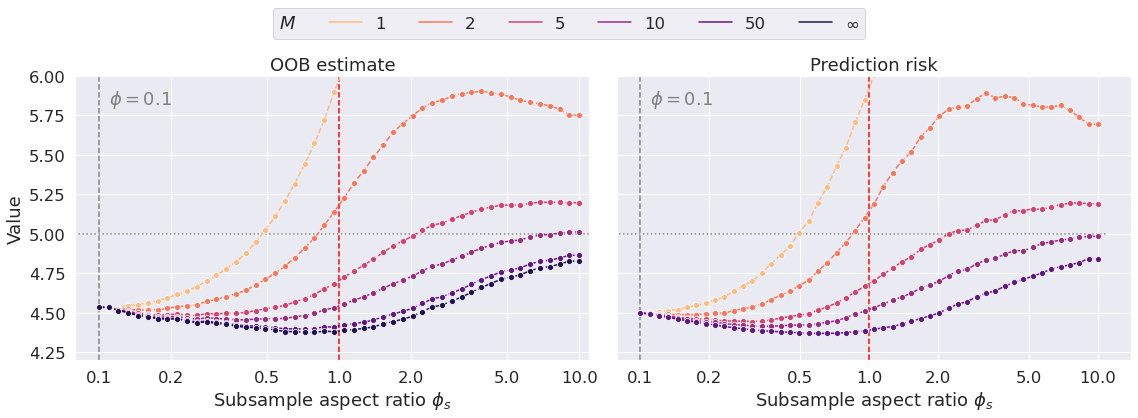

In [13]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 1.05*sigma**2, 1.5*sigma**2
y_text_list = [y_max * 0.97, y_max * 0.97]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 0.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])

axes[0].set_xlim([0.08, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_lasso_{:.01f}_phi_0.1.pdf'.format(lam),
            bbox_inches='tight', pad_inches=0, dpi=300)

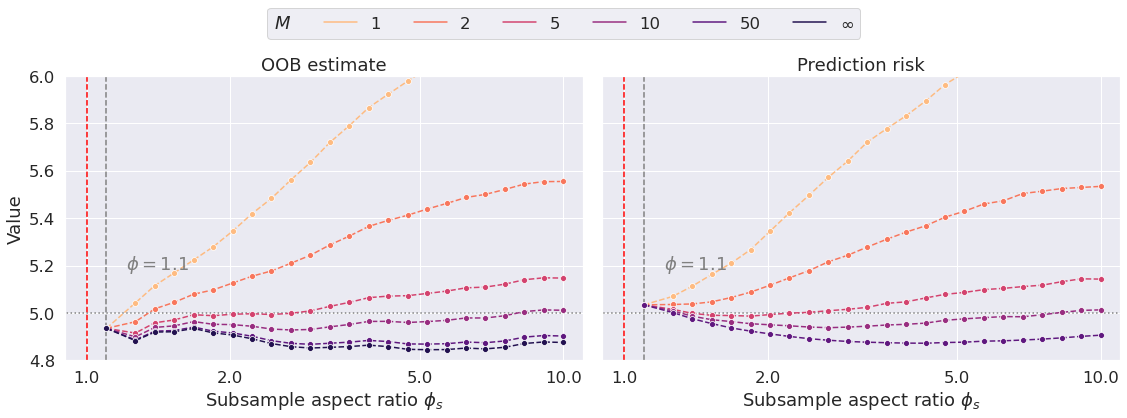

In [14]:
sns.set(font_scale=1.5)

sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 1.2*sigma**2, 1.5*sigma**2
y_text_list = [y_min * 1.08, y_min * 1.08]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 1.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    

    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])


    axes[j].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_lasso_{:.01f}_phi_1.1.pdf'.format(lam),
            bbox_inches='tight', pad_inches=0, dpi=300)

## KNN

In [15]:
rho = 1.
SNR = 0.25
lam = 0.
sigma = rho / np.sqrt(SNR)

M_list = np.array([1, 2, 5, 10, 25])
M_str = np.append(M_list.astype(str), ['$\infty$'])

df_res = pd.DataFrame()
df_res_the = pd.DataFrame()
path_result = 'result/ex1/kNN/'
for phi in [0.1, 1.1]:
    _df = pd.read_csv(path_result+'res_phi_{:.01f}_SNR_{:.02f}.csv'.format(
        phi, SNR))
    _df.columns = ['phi_s','seed', 'type']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist() + [r'risk-0']
    _df = pd.wide_to_long(_df, stubnames='risk', i=['phi_s', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
    _df['M'] = _df['M'].astype(int).astype(str)
    _df.loc[_df['M']=='0','M'] = '$\infty$'    
    _df = _df[_df['M'].isin(M_str)]
    _df['phi'] = phi
    df_res = pd.concat([df_res, _df], axis=0)

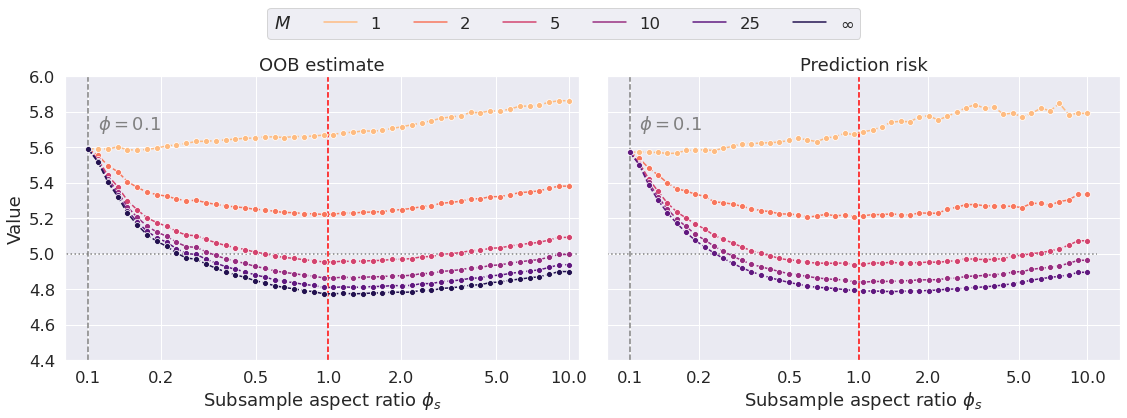

In [16]:
sns.set(font_scale=1.5)

sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 1.1*sigma**2, 1.5*sigma**2
y_text_list = [y_max * 0.95, y_max * 0.95]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 0.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,] #if j==0 else [1,2,5,10]#axes[1].get_xticks()[::2]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])

axes[0].set_xlim([0.08, 11])
# axes[1].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_kNN_phi_0.1.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)    

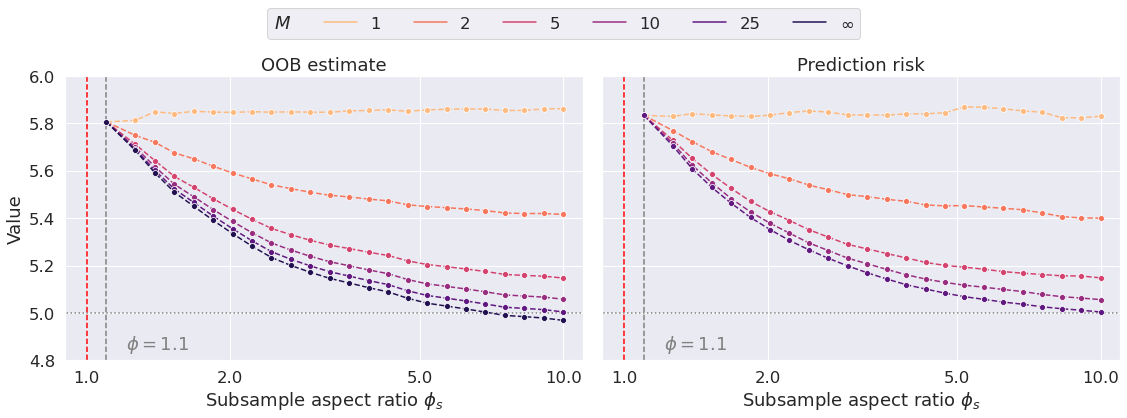

In [17]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 1.2*sigma**2, 1.5*sigma**2
y_text_list = [y_min * 1.01, y_min * 1.01]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 1.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [1,2,5,10]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])

    axes[j].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_kNN_phi_1.1.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Logistic

In [18]:
rho = 1.
SNR = 0.25
lam = 0.
sigma = rho / np.sqrt(SNR)

M_list = np.array([1, 2, 5, 10, 25])
M_str = np.append(M_list.astype(str), ['$\infty$'])

df_res = pd.DataFrame()
df_res_the = pd.DataFrame()
path_result = 'result/ex1/logistic/'
for phi in [0.1, 1.1]:
    _df = pd.read_csv(path_result+'res_phi_{:.01f}_lam_{:.01f}_SNR_{:.02f}.csv'.format(
        phi, lam, SNR))
    _df.columns = ['phi_s','seed', 'type']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist() + [r'risk-0']
    _df = pd.wide_to_long(_df, stubnames='risk', i=['phi_s', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
    _df['M'] = _df['M'].astype(int).astype(str)
    _df.loc[_df['M']=='0','M'] = '$\infty$'    
    _df = _df[_df['M'].isin(M_str)]
    _df['phi'] = phi
    df_res = pd.concat([df_res, _df], axis=0)

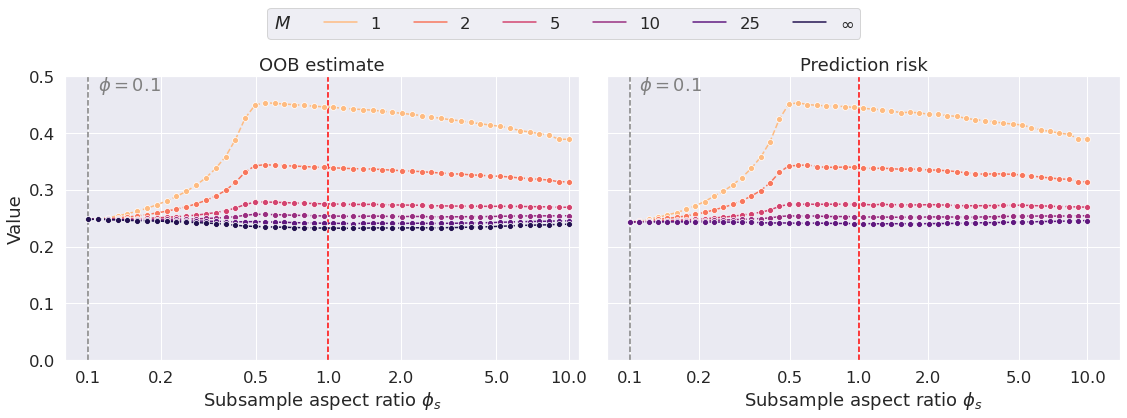

In [19]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 0.,0.5
y_text_list = [y_max * 0.95, y_max * 0.95]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 0.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    
    
    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])

axes[0].set_xlim([0.08, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_logisticless_phi_0.1.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

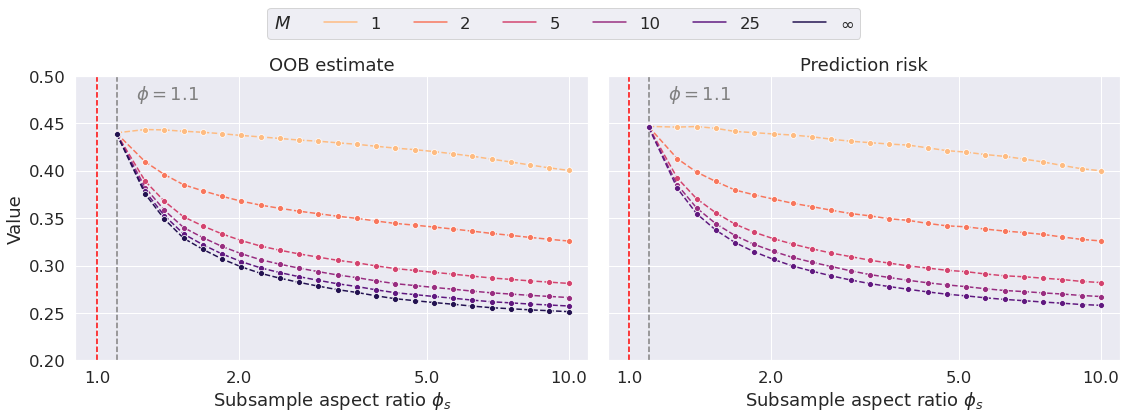

In [20]:
sns.set(font_scale=1.5)


sigma2 = sigma**2
rho2 = rho**2
null_risk = rho2 + sigma2
y_min, y_max = 0.2,0.5
y_text_list = [y_max * 0.95, y_max * 0.95]


hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
df_res_emp = df_res[df_res['type']=='risk_emp']
df_res_oob = df_res[df_res['type']=='oobcv_emp']

fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})
phi = 1.1
for j in range(2):
    axes[j].hlines(null_risk, 0,11, linestyles='dotted', color='gray')
    axes[j].vlines(phi, y_min, y_max,
              linestyles='--', color='gray')
    axes[j].vlines(1., y_min, y_max,
              linestyles='--', color='red')
    axes[j].text(phi*1.1,y_text_list[j],'$\phi={:.01f}$'.format(phi), color='gray')
    

    if j==1:
        sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_emp['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('Prediction risk')
    else:
        sns.lineplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))], x='phi_s', y='risk', hue='M', ci=None, 
                 linestyle='--', marker='o', palette=cm[:len(np.unique(df_res_oob['M']))],# linewidth=2,
                ax=axes[j])
        axes[j].set_title('OOB estimate')
    axes[j].set_xlabel('Subsample aspect ratio $\phi_s$')
    
    axes[j].set_xscale('log', base=10)
    
axes[0].set_ylabel('Value')

axes[0].set_ylim([y_min, y_max])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,]
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels([ f"{x:.01f}" for x in ticks ])


    axes[j].set_xlim([0.9, 11])

fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0].get_legend().remove()
axes[1].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=9, title='$M$')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.savefig('result/fig_iso_logisticless_phi_1.1.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

# Section 5.2

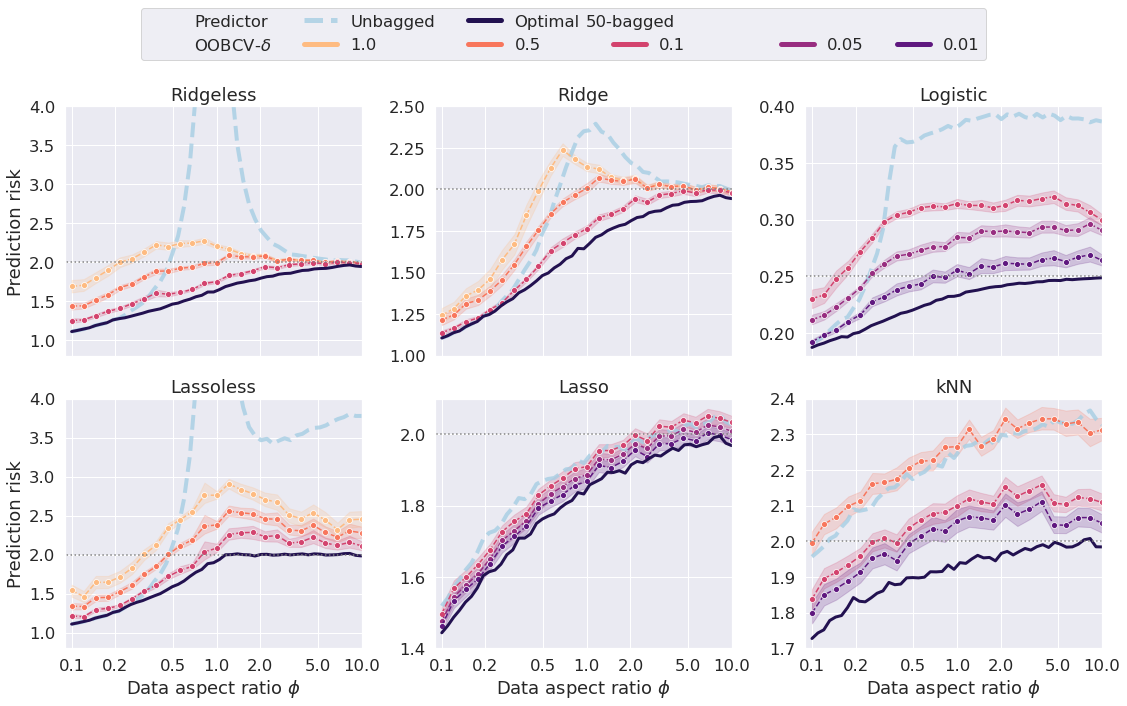

In [21]:
sigma = 1.


delta_dict = {
    'ridgeless':np.array([1e-1, 5e-1, 1e0]),
    'ridge':np.array([1e-1, 5e-1, 1e0]),
    'lassoless':np.array([1e-1, 5e-1, 1e0]),
    'lasso':np.array([1e-2, 5e-2, 1e-1]),
    'logistic':np.array([1e-2, 5e-2, 1e-1]),
    'kNN':np.array([1e-2, 1e-1, 5e-1]),
}

M_list = [1,5,25]
M_str = np.array(M_list +['$\infty$'], dtype=str)

df_res = pd.DataFrame()
df_res_the = pd.DataFrame()
df_res_the_cv = pd.DataFrame()
SNR = 1
pred_list = ['ridgeless', 'ridge', 'logistic',
             'lassoless', 'lasso', 'kNN']
for predictor in pred_list:
    lam = 0.1 if predictor in ['ridge', 'lasso'] else 0.
        
    
    path_result = 'result/ex2/{}/'.format(predictor.replace('less', ""))
    delta_list = delta_dict[predictor]
    delta_str = np.char.add('delta-', delta_list.astype(str))
    rho = sigma*np.sqrt(SNR)

    if predictor in ['kNN','tree']:
        _df = pd.read_csv(path_result+'res_iso_cv_SNR_{:.02f}.csv'.format(SNR), index_col=0).reset_index(drop=True)
    else:
        _df = pd.read_csv(path_result+'res_iso_cv_lam_{:.01f}_SNR_{:.02f}.csv'.format(lam, SNR), index_col=0).reset_index(drop=True)
    null_risk = _df.loc[_df['k_list']==np.inf,_df.columns.str.startswith('val-')].values.mean()    
    _df.loc[np.any(_df[['val-1','val-2']] > np.minimum(10*null_risk, 1e5), axis=1), ['val-1','val-2']] = np.nan
    _df['diff_2R2_R1'] = 2 * _df['val-2'] - _df['val-1']

    _df = _df.loc[_df.groupby(['phi','seed'])['diff_2R2_R1'].idxmin()].reset_index(drop=True)
    _df['diff_R1_R2'] = _df['val-1'] - _df['val-2']

    _df[np.char.add('M_hat-',delta_str)] = np.minimum(np.ceil(_df['diff_R1_R2'][:,None] * 2 / delta_list[None,:]), 50).astype(int)
    _df[np.char.add('risk-',delta_str)] = np.take_along_axis(
        _df.loc[:,_df.columns.str.startswith('test-')].values,
        _df[np.char.add('M_hat-',delta_str)].values - 1, axis=-1
    )
    _df['phi_s'] = _df['phi']*1000/_df['k_list']
    
    _df = _df[np.r_[[
        'phi', 'phi_s', 'seed'], np.char.add('M_hat-',delta_str), np.char.add('risk-',delta_str)]
         ]
    _df = pd.wide_to_long(
        _df, stubnames=[r'M_hat', r'risk'], 
        i=['phi', 'phi_s', 'seed'], j='delta', sep='-delta-', suffix='.*'
    ).reset_index()
    _df['Predictor'] = predictor
    df_res = pd.concat([df_res, _df], axis=0)
    
    if predictor in ['kNN','tree']:
        _df = pd.read_csv(path_result+'res_iso_risk_SNR_{:.02f}.csv'.format(SNR), index_col=0)
    else:
        _df = pd.read_csv(path_result+'res_iso_risk_lam_{:.01f}_SNR_{:.02f}.csv'.format(lam, SNR), index_col=0)
    _df.columns = ['phi','phi_s']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist()
    _df = _df.drop_duplicates(['phi','phi_s'])
    _df = pd.wide_to_long(_df, stubnames='risk', i=['phi', 'phi_s'], j='M', sep='-').reset_index()

    _df['M'] = _df['M'].astype(int).astype(str)
    _df['Predictor'] = predictor

    df_res_the_cv = pd.concat([
        df_res_the_cv, _df.loc[_df.groupby(['Predictor','phi','M'])['risk'].idxmin()]], axis=0)
    _df = _df[_df['M']=='1']
    df_res_the = pd.concat([
        df_res_the, _df.loc[_df.groupby(['Predictor','phi'])['phi_s'].idxmin()]], axis=0)

import itertools

sns.set(font_scale=1.5)


ylim_dict = {
    'lassoless':[0.8, 4],
    'lasso':[1.4, 2.1],
    'ridgeless':[0.8, 4],
    'ridge':[1., 2.5],    
    'logistic':[0.18, 0.4],    
    'kNN':[1.7, 2.4],
}
pred_list = ['ridgeless', 'ridge', 'logistic',
             'lassoless', 'lasso', 'kNN']
delta_list_all = -np.sort(-np.array([1e-2, 5e-2, 1e-1, 5e-1, 1e0]))
hue_order = M_str
cm = sns.color_palette("magma_r", len(delta_list_all)+1)

fig, axes = plt.subplots(
    2,3,figsize=(16,10), sharex=True, sharey=False)

for i,j in itertools.product(np.arange(2), np.arange(3)):
    predictor = pred_list[i*3+j]


    delta_list = delta_dict[predictor]
    delta_str = np.char.add('delta-', delta_list.astype(str))

    rho = sigma*np.sqrt(SNR)    
    sigma2 = sigma**2
    rho2 = rho**2
    null_risk = 0.25 if predictor=='logistic' else rho2 + sigma2

    sns.lineplot(data=df_res_the[df_res_the['Predictor']==predictor], x='phi', y='risk', 
                 linestyle='--', ci=None, legend='full', linewidth=4,
                 color=sns.color_palette("Paired")[0], 
                 alpha=0.8, ax=axes[i,j], label='Unbagged')

    sns.lineplot(data=df_res[df_res['Predictor']==predictor], x='phi', y='risk', 
                 hue='delta', hue_order=delta_list[::-1],
                 linestyle='dashed', marker='o',
                 palette=[cm[j] for j in np.where(np.in1d(delta_list_all, delta_dict[predictor]))[0]],#cm[:len(M_str)-1], 
                 ax=axes[i,j],
                )
    sns.lineplot(data=df_res_the_cv[
        (df_res_the_cv['Predictor']==predictor)&(df_res_the_cv['M']=='50')], x='phi', y='risk', 
                 linestyle='-', ci=None, linewidth=3,
                 color=cm[-1], ax=axes[i,j], label='Optimal 50-bagged')

    axes[i,j].set_title('{}'.format(
        np.char.capitalize(predictor) if predictor!='kNN' else 'kNN'
    ))
    axes[i,j].set_xlabel('Data aspect ratio $\phi$')
    axes[i,j].legend(loc='lower right', title='$M$')
    axes[i,j].hlines(null_risk, 0., 10.,
              linestyles='dotted', color='gray')

    axes[i,j].set_ylim(ylim_dict[predictor])

axes[i,0].set_xscale('log', base=10)
axes[i,0].set_xlim([0.09, 10.])
ticks = [0.1,0.2,0.5,1.,2.,5.,10.,]
axes[i,0].set_xticks(ticks, [ f"{x:.01f}" for x in ticks ])

import matplotlib
lines_labels = [ax.get_legend_handles_labels() for ax in axes.flatten()]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
_, indices = np.unique(labels, return_index=True)
indices = indices[::-1]
handles = np.array(handles)[indices].tolist()
labels = np.array(labels)[indices].tolist()

for i,j in itertools.product(np.arange(2), np.arange(3)):
    if j!=0:
        axes[i,j].set_ylabel('')
    else:
        axes[i,j].set_ylabel('Prediction risk')
    axes[i,j].get_legend().remove()

handles = [matplotlib.lines.Line2D([], [], color="none") for _ in range(2)] + \
    [handles[0], handles[2], handles[1], handles[3], 
     matplotlib.lines.Line2D([], [], color="none"), handles[4],
     matplotlib.lines.Line2D([], [], color="none"), handles[5],
     matplotlib.lines.Line2D([], [], color="none"), handles[6]]
labels = ['Predictor', 'OOBCV-$\delta$', labels[0], labels[2],
         'Optimal', labels[3], '50', labels[4], '', labels[5], '', labels[6]]
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=6, title='')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    if label._text  in ['50']:
        width=item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-2.2*width,0))
        label.set_text('50-bagged')
    item.set_linewidth(5)
        
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_iso_cv.pdf'.format(lam), bbox_inches='tight', pad_inches=0, dpi=300)    

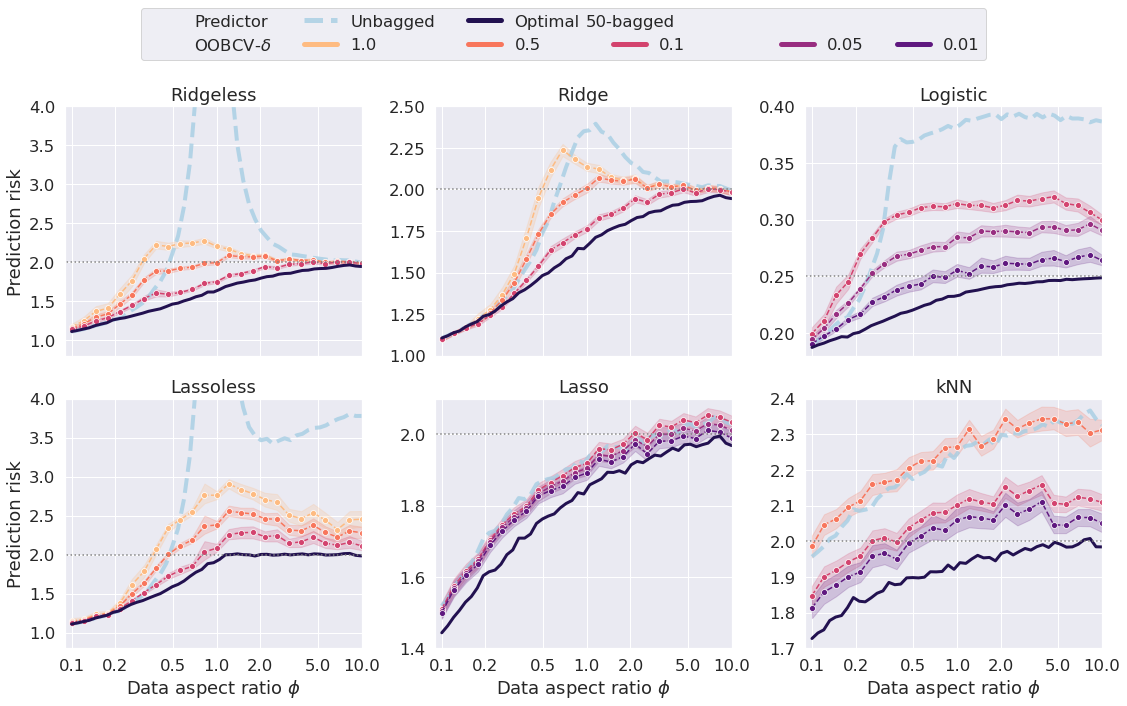

In [22]:
sigma = 1.


delta_dict = {
    'ridgeless':np.array([1e-1, 5e-1, 1e0]),
    'ridge':np.array([1e-1, 5e-1, 1e0]),
    'lassoless':np.array([1e-1, 5e-1, 1e0]),
    'lasso':np.array([1e-2, 5e-2, 1e-1]),
    'logistic':np.array([1e-2, 5e-2, 1e-1]),
    'kNN':np.array([1e-2, 1e-1, 5e-1]),
}

M_list = [1,5,25]
M_str = np.array(M_list +['$\infty$'], dtype=str)

df_res = pd.DataFrame()
df_res_the = pd.DataFrame()
df_res_the_cv = pd.DataFrame()
SNR = 1
pred_list = ['ridgeless', 'ridge', 'logistic',
             'lassoless', 'lasso', 'kNN']
for predictor in pred_list:
    lam = 0.1 if predictor in ['ridge', 'lasso'] else 0.
        
    
    path_result = 'result/ex2/{}/'.format(predictor.replace('less', ""))
    delta_list = delta_dict[predictor]
    delta_str = np.char.add('delta-', delta_list.astype(str))
    rho = sigma*np.sqrt(SNR)

    if predictor in ['kNN','tree']:
        _df = pd.read_csv(path_result+'res_iso_cv_SNR_{:.02f}.csv'.format(SNR), index_col=0).reset_index(drop=True)
    else:
        _df = pd.read_csv(path_result+'res_iso_cv_lam_{:.01f}_SNR_{:.02f}.csv'.format(lam, SNR), index_col=0).reset_index(drop=True)
    null_risk = _df.loc[_df['k_list']==np.inf,_df.columns.str.startswith('val-')].values.mean()    
    _df.loc[np.any(_df[['val-1','val-2']] > np.minimum(10*null_risk, 1e5), axis=1), ['val-1','val-2']] = np.nan
    _df['diff_2R2_R1'] = 2 * _df['val-2'] - _df['val-1']
    _df['diff_R1_R2'] = _df['val-1'] - _df['val-2']
    
    is_bag = _df.groupby(['phi','seed']).apply(
        lambda grp: 
        (grp['val-1'].min() - (grp['diff_2R2_R1'] + 2/50*grp['diff_R1_R2']).min()
        >= (grp.loc[grp['k_list']==np.inf,'val-1'].mean() - grp['val-1'].min())) |
        (grp['val-1'].min() - (grp['diff_2R2_R1'] + 2/50*grp['diff_R1_R2']).min()
        >= 0.1*grp['val-1'].min())
    ).reset_index(drop=True)
    df = _df.loc[_df.groupby(['phi','seed'])['diff_2R2_R1'].idxmin()].reset_index(drop=True)
    df = df.where(
        is_bag, 
        _df.loc[_df.groupby(['phi','seed'])['val-1'].idxmin()].reset_index(drop=True)
    )

    df[np.char.add('M_hat-',delta_str)] = np.minimum(np.ceil(df['diff_R1_R2'][:,None] * 2 / delta_list[None,:]), 50).astype(int)
    df[np.char.add('risk-',delta_str)] = np.take_along_axis(
        df.loc[:,df.columns.str.startswith('test-')].values,
        df[np.char.add('M_hat-',delta_str)].values - 1, axis=-1
    )
    df['phi_s'] = df['phi']*1000/df['k_list']
    
    df = df[np.r_[[
        'phi', 'phi_s', 'seed'], np.char.add('M_hat-',delta_str), np.char.add('risk-',delta_str)]
         ]
    df = pd.wide_to_long(
        df, stubnames=[r'M_hat', r'risk'], 
        i=['phi', 'phi_s', 'seed'], j='delta', sep='-delta-', suffix='.*'
    ).reset_index()
    df['Predictor'] = predictor
    df_res = pd.concat([df_res, df], axis=0)
    
    if predictor in ['kNN','tree']:
        _df = pd.read_csv(path_result+'res_iso_risk_SNR_{:.02f}.csv'.format(SNR), index_col=0)
    else:
        _df = pd.read_csv(path_result+'res_iso_risk_lam_{:.01f}_SNR_{:.02f}.csv'.format(lam, SNR), index_col=0)
    _df.columns = ['phi','phi_s']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist()
    _df = _df.drop_duplicates(['phi','phi_s'])
    _df = pd.wide_to_long(_df, stubnames='risk', i=['phi', 'phi_s'], j='M', sep='-').reset_index()

    _df['M'] = _df['M'].astype(int).astype(str)
    _df['Predictor'] = predictor

    df_res_the_cv = pd.concat([
        df_res_the_cv, _df.loc[_df.groupby(['Predictor','phi','M'])['risk'].idxmin()]], axis=0)
    _df = _df[_df['M']=='1']
    df_res_the = pd.concat([
        df_res_the, _df.loc[_df.groupby(['Predictor','phi'])['phi_s'].idxmin()]], axis=0)

import itertools

sns.set(font_scale=1.5)


ylim_dict = {
    'lassoless':[0.8, 4],
    'lasso':[1.4, 2.1],
    'ridgeless':[0.8, 4],
    'ridge':[1., 2.5],    
    'logistic':[0.18, 0.4],    
    'kNN':[1.7, 2.4],
}
pred_list = ['ridgeless', 'ridge', 'logistic',
             'lassoless', 'lasso', 'kNN']
delta_list_all = -np.sort(-np.array([1e-2, 5e-2, 1e-1, 5e-1, 1e0]))
hue_order = M_str
cm = sns.color_palette("magma_r", len(delta_list_all)+1)

fig, axes = plt.subplots(
    2,3,figsize=(16,10), sharex=True, sharey=False)

for i,j in itertools.product(np.arange(2), np.arange(3)):
    predictor = pred_list[i*3+j]


    delta_list = delta_dict[predictor]
    delta_str = np.char.add('delta-', delta_list.astype(str))

    rho = sigma*np.sqrt(SNR)    
    sigma2 = sigma**2
    rho2 = rho**2
    null_risk = 0.25 if predictor=='logistic' else rho2 + sigma2

    sns.lineplot(data=df_res_the[df_res_the['Predictor']==predictor], x='phi', y='risk', 
                 linestyle='--', ci=None, legend='full', linewidth=4,
                 color=sns.color_palette("Paired")[0], 
                 alpha=0.8, ax=axes[i,j], label='Unbagged')

    sns.lineplot(data=df_res[df_res['Predictor']==predictor], x='phi', y='risk', 
                 hue='delta', hue_order=delta_list[::-1],
                 linestyle='dashed', marker='o',
                 palette=[cm[j] for j in np.where(np.in1d(delta_list_all, delta_dict[predictor]))[0]],#cm[:len(M_str)-1], 
                 ax=axes[i,j],
                )
    sns.lineplot(data=df_res_the_cv[
        (df_res_the_cv['Predictor']==predictor)&(df_res_the_cv['M']=='50')], x='phi', y='risk', 
                 linestyle='-', ci=None, linewidth=3,
                 color=cm[-1], ax=axes[i,j], label='Optimal 50-bagged')

    axes[i,j].set_title('{}'.format(
        np.char.capitalize(predictor) if predictor!='kNN' else 'kNN'
    ))
    axes[i,j].set_xlabel('Data aspect ratio $\phi$')
    axes[i,j].legend(loc='lower right', title='$M$')
    axes[i,j].hlines(null_risk, 0., 10.,
              linestyles='dotted', color='gray')

    axes[i,j].set_ylim(ylim_dict[predictor])

axes[i,0].set_xscale('log', base=10)
axes[i,0].set_xlim([0.09, 10.])
ticks = [0.1,0.2,0.5,1.,2.,5.,10.,]
axes[i,0].set_xticks(ticks, [ f"{x:.01f}" for x in ticks ])

import matplotlib
lines_labels = [ax.get_legend_handles_labels() for ax in axes.flatten()]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
_, indices = np.unique(labels, return_index=True)
indices = indices[::-1]
handles = np.array(handles)[indices].tolist()
labels = np.array(labels)[indices].tolist()

for i,j in itertools.product(np.arange(2), np.arange(3)):
    if j!=0:
        axes[i,j].set_ylabel('')
    else:
        axes[i,j].set_ylabel('Prediction risk')
    axes[i,j].get_legend().remove()

handles = [matplotlib.lines.Line2D([], [], color="none") for _ in range(2)] + \
    [handles[0], handles[2], handles[1], handles[3], 
     matplotlib.lines.Line2D([], [], color="none"), handles[4],
     matplotlib.lines.Line2D([], [], color="none"), handles[5],
     matplotlib.lines.Line2D([], [], color="none"), handles[6]]
labels = ['Predictor', 'OOBCV-$\delta$', labels[0], labels[2],
         'Optimal', labels[3], '50', labels[4], '', labels[5], '', labels[6]]
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=6, title='')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    if label._text in ['50']:
        width=item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-2.2*width,0))
        label.set_text('50-bagged')
    item.set_linewidth(5)
        
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_iso_cv_bag_and_unbag.pdf'.format(lam), bbox_inches='tight', pad_inches=0, dpi=300)

# Section 5.3

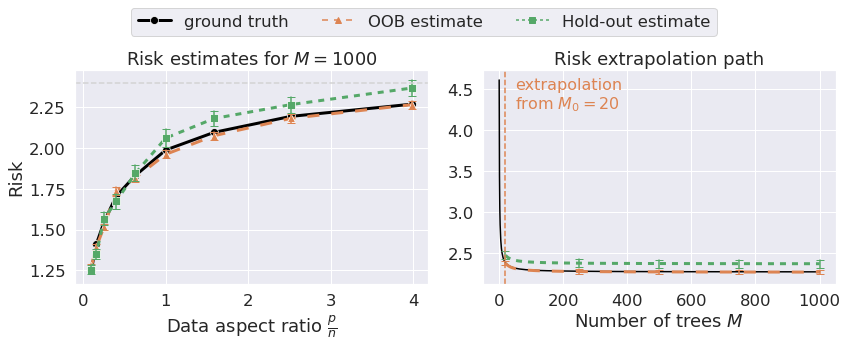

In [23]:
ar1rho = 0.75
path_result = 'result/ex3/tree/'

_df = pd.read_csv(path_result+'res_ar1_cv_ar1rho_{:.02f}.csv'.format(ar1rho), index_col=0)
null_risk = (_df['rho2'] + _df['sigma2']).mean()
_df.columns = ['phi','seed', 'type', 'rho2', 'sigma2']+np.char.add('risk-',np.arange(1,1001).astype(str)).tolist() + [r'risk-0']
_df = pd.wide_to_long(_df, stubnames='risk', i=['phi', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
_df.loc[_df['M']==0,'M'] = np.inf

_df = _df.sort_values(['phi','seed','M'])

sns.set(font_scale=1.5)

hue_order = ['risk_emp', 'oobcv_emp', 'hold_emp']
cm = sns.color_palette()

fig, axes = plt.subplots(1,2,figsize=(12,5))
ids = (_df['phi']<6.)
sns.lineplot(data=_df[ids&(_df['type']=='risk_emp')&(_df['M']==1000)], 
             x='phi', y='risk', lw=3, markersize=8,
             marker='o', color='black', ci=None, 
             label='ground truth', ax=axes[0])
sns.lineplot(data=_df[ids&(_df['type']!='risk_emp')&(_df['M']==1000)], 
             x='phi', y='risk', lw=3, markersize=8, 
             style='type', style_order=hue_order[1:3], 
             dashes=[(4,4),(2,2)], markers=['^', 's'], 
             errorbar=("se", 1), err_style='bars', err_kws={'capsize':4,'capthick':1},#  linestyle='--', style=['s','.'],
             hue='type', hue_order=hue_order[1:3], palette=cm[1:3], ax=axes[0])

axes[0].set_xlabel('Data aspect ratio $\\frac{p}{n}$')
axes[0].set_title('Risk estimates for $M=1000$')
axes[0].set_ylabel('Risk')

xlim = axes[0].get_xlim()
axes[0].hlines(null_risk, xlim[0], xlim[1], linestyle='--', color='lightgray')
axes[0].set_xlim(xlim)

ids = (_df['phi']>3)&(_df['phi']<4)
sns.lineplot(
    data=_df[ids&(_df['type']=='risk_emp')], 
    x='M', y='risk', color='black', ci=None, label='ground truth', ax=axes[1])
sns.lineplot(data=_df[ids&(_df['type']!='risk_emp')&(_df['M']>20)],             
             x='M', y='risk', lw=3,
             style='type', style_order=hue_order[1:3], 
             dashes=[(4,4),(2,2)], ci=None,
             hue='type', hue_order=hue_order[1:3], palette=cm[1:3], ax=axes[1])
sns.lineplot(data=_df[ids&(_df['type']!='risk_emp')&(_df['M'].isin([20,250, 500, 750, 1000]))],             
             x='M', y='risk', lw=3, markersize=8,  linestyle='',
             style='type', style_order=hue_order[1:3], 
             dashes=[(0,4),(0,2)], legend=False, #markers=['^', 's'], 
             errorbar=("se", 1), err_style='bars', err_kws={'capsize':4,'capthick':1},#  linestyle='--', style=['s','.'],
             hue='type', hue_order=hue_order[1:3], palette=cm[1:3], ax=axes[1])
axes[1].set_xlabel('Number of trees $M$')
axes[1].set_title('Risk extrapolation path')
axes[1].set_ylabel('')

ylim = axes[1].get_ylim()
axes[1].vlines(20, ylim[0], ylim[1], linestyle='--', color=cm[1])
axes[1].set_ylim(ylim)
axes[1].text(50, ylim[1]*0.9, 'extrapolation\nfrom $M_0=20$', 
             color=cm[1], fontsize=16)


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

for j in range(2):
    axes[j].get_legend().remove()

legend = fig.legend(handles=handles, 
                    labels=['ground truth', 'OOB estimate', 'Hold-out estimate'], loc=9, ncol=9)

fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.savefig('result/fig_ar1_rf.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Section 6

In [24]:
with h5py.File('pbmc_count.h5', 'r') as f:
    print(f.keys())
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32).T.toarray()
    Y = np.array(f['ADT'], dtype=np.float32)
    cell_types = np.array(f['celltype'], dtype='S32').astype(str)
    cell_ids = np.array(f['cell_ids'], dtype='S32').astype(str)
    
X = np.log(X/np.sum(X, axis=1, keepdims=True)*1e4+1.)
Y = np.log(Y/np.sum(Y, axis=1, keepdims=True)*1e4+1.)

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'cell_ids', 'celltype', 'gene_names']>


## Figure 1

In [25]:
df_split = pd.read_csv('df_split.csv', index_col=[0])
df_split['celltype'] = cell_types
df_split = df_split[df_split['split']=='train']
df_split['count'] = 1
df_split = df_split.groupby(['celltype','split']).count().reset_index()


cell_types_list = ['B', 'DC', 'Mono', 'NK']
method_list = ['ridge', 'lasso', 'tree'] 
method = method_list[2]
res_cv_all = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex4/{}/{}/'.format(celltype,method)

    res_cv = []
    cv_method_dict = {
        'splitcv':'splitCV', 
        'kfoldcv':'KfoldCV',
        'oobcv_50':'OOBCV',
        'oobcv_100':'OOBCV-100',
        'oobcv_250':'OOBCV-250',
    }

    for j,ADT_name in enumerate(ADT_names):
        for cv_method in [
            'splitcv', 'kfoldcv', 'oobcv_250', 
#             'oobcv_100', 'oobcv_250',
        ]:
            file_name = path_result + 'res_ADT_{}_{}.csv'.format(j, cv_method.split('-')[0])
            if os.path.exists(file_name):
                df = pd.read_csv(file_name, index_col=0)
            else:
                print(file_name)
                continue
            df = df.sort_values('k_list')

                            
            if cv_method=='splitcv':
                k_hat = np.unique(df['k_list'].values)
                
            if cv_method in ['kfoldcv']:
                df.loc[df['k_list']==0,df.columns.str.startswith('test')] = null_risk

            if cv_method.startswith('oobcv') and (not cv_method.endswith('full')):
                df = df[df['k_list'].isin(k_hat)]

            null_risk = df.loc[df['k_list']==0,df.columns.str.startswith('val')].mean().mean()
            res_val = df.loc[:,df.columns.str.startswith('val')].values / null_risk
            null_risk = df.loc[df['k_list']==0,df.columns.str.startswith('test')].mean().mean()
            res_test = df.loc[:,df.columns.str.startswith('test')].values / null_risk
            if cv_method=='kfoldcv':
                res_val[:,10:] = np.inf
                res_test[:,10:] = np.inf
            res_val[:,50:] = np.inf
            res_test[:,50:] = np.inf
            for delta in [0.025, 0.05, 0.1]:
                idk, idM = np.where(res_val <= np.min(res_val) + delta)
                idMhat = np.min(idM)
                idkhat = np.argmin(res_val[:,idMhat])
                subopt = res_test[idkhat, idMhat] - np.min(res_test)

                res_cv.append([
                    ADT_name,
                    delta,
                    idMhat if cv_method!='kfoldcv' else 5*idMhat,
                    int(k_hat[idkhat]),
                    cv_method_dict[cv_method], 
                    subopt
                ])
    res_cv = pd.DataFrame(res_cv, columns=['ADT_name', 'delta', 'M', 'k', 'cv_method', 'subopt'])
    res_cv['celltype'] = celltype
    res_cv_all = pd.concat([res_cv_all, res_cv], axis=0)
cell_types_list = np.array(['DC', 'B', 'NK', 'Mono',])
res_cv_all = res_cv_all.sort_values(
    'celltype', key=lambda x:x.map({j:i for i,j in enumerate(cell_types_list)}))
res_cv_all['xlabels'] = res_cv_all['celltype'].map(
    {j:j+'\n$n$={:d}'.format(
        df_split.loc[df_split['celltype']==j,'count'].iloc[0]
    ) for i,j in enumerate(cell_types_list)})
res_cv_all.loc[res_cv_all['cv_method'] == 'OOBCV-250', 'cv_method'] = 'OOBCV'

In [26]:
cv_method_dict = {
    'splitcv':'splitCV', 
    'kfoldcv':'KfoldCV',
    'oobcv-50':'OOBCV-50',
    'oobcv-100':'OOBCV-100',
    'oobcv-250':'OOBCV-250',
}
cell_types_list = ['B', 'DC', 'Mono', 'NK']

df = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex4/{}/{}/'.format(celltype,method)

    res_cv = []

    _df = pd.read_csv(path_result+'res_time_{}.csv'.format(method), index_col=0)
    _df = pd.melt(_df, id_vars=['ADT_name'], value_vars=[
        'splitcv', 'oobcv-50','oobcv-100','oobcv-250','kfoldcv',
    ],
           var_name='cv_method', value_name='time')
    _df['cv_method'] = _df['cv_method'].apply(lambda x:cv_method_dict[x])
    _df['celltype'] = celltype
    df = pd.concat([df, _df], axis=0)


cell_types_list = np.array(['DC', 'B', 'NK', 'Mono',])
df = df.sort_values(
    'celltype', key=lambda x:x.map({j:i for i,j in enumerate(cell_types_list)}))
df['xlabels'] = df['celltype'].map(
    {j:j+'\n$n$={:d}'.format(
        df_split.loc[df_split['celltype']==j,'count'].iloc[0]
    ) for i,j in enumerate(cell_types_list)})
df = df[df['cv_method'].isin(['splitCV','KfoldCV','OOBCV-250'])]
df = df.reset_index(drop=True)
df.loc[df['cv_method'] == 'OOBCV-250', 'cv_method'] = 'OOBCV'

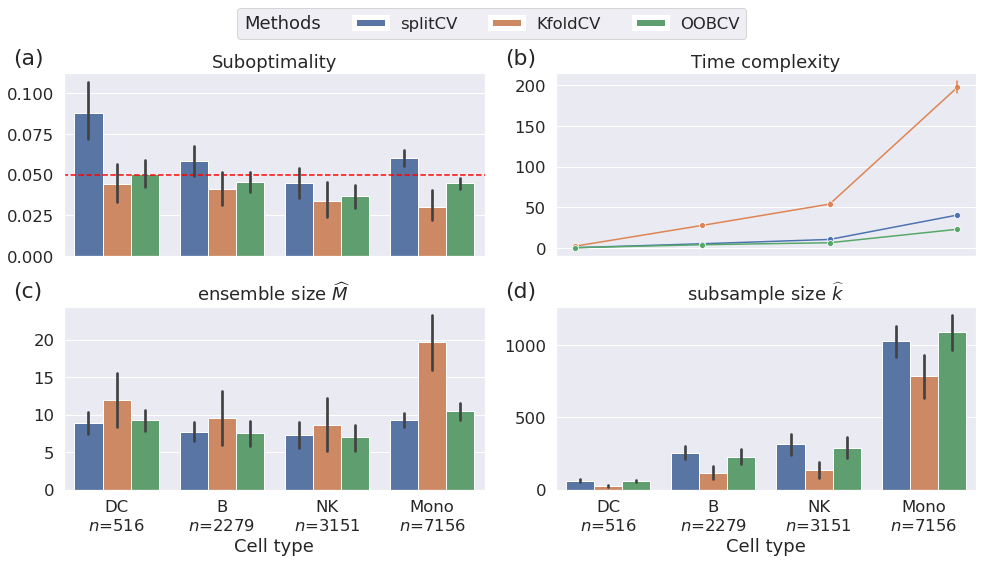

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(font_scale=1.5)
fig, axes = plt.subplots(2,2,figsize=(14,8))

sns.barplot(
    data=res_cv_all[res_cv_all['delta']==0.05], x='xlabels', y='subopt', 
    hue='cv_method', ax=axes[0,0],# order= cell_types_list
)
xlim = axes[0,0].get_xlim()
axes[0,0].hlines(0.05, xlim[0]-1, xlim[1]+1, 
               linestyle='--', color='red', zorder=1)
axes[0,0].set_xlim(xlim)
axes[0,0].set_title('Suboptimality')

sns.barplot(
    data=res_cv_all[res_cv_all['delta']==0.05], x='xlabels', y='M', 
    hue='cv_method', ax=axes[1,0], # order= cell_types_list
)
axes[1,0].set_title('ensemble size $\widehat{M}$')

sns.barplot(
    data=res_cv_all[res_cv_all['delta']==0.05], x='xlabels', y='k',
    hue='cv_method', ax=axes[1,1], # order= cell_types_list
)
axes[1,1].set_title('subsample size $\widehat{k}$')

sns.lineplot(
    data=df, x='xlabels', hue='cv_method', y='time', marker='o',
    estimator='mean', err_style='bars', hue_order=['splitCV','KfoldCV','OOBCV'], ax=axes[0,1], sort= False)


for i in range(2):
    for j in range(2):
        if i==1:
            xlabel = 'Cell type'
            
        else:
            axes[i,j].set_xticks([])
            xlabel = ''
        axes[i,j].set_xlabel(xlabel)
        axes[i,j].set_ylabel('')
axes[0,1].set_title('Time complexity')
# axes[2].yaxis.tick_right()
# axes[2].yaxis.set_label_position("right")

num = ['(a)', '(b)', '(c)', '(d)']
for i in range(2):
    for j in range(2):
        axes[i,j].text(-.12, 1.05, num[int(i*2+j)], 
                     size=22, transform=axes[i,j].transAxes)

import matplotlib
axes[0,0].get_legend().set_title('Method')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]


for i in range(2):
    for j in range(2):
        axes[i,j].get_legend().remove()

legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=5, title='Methods')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    item.set_linewidth(5)
    label.set_ha('left')
    
plt.tight_layout()
fig.subplots_adjust(top=0.87)
plt.savefig('result/real_data_overview.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Figure 6

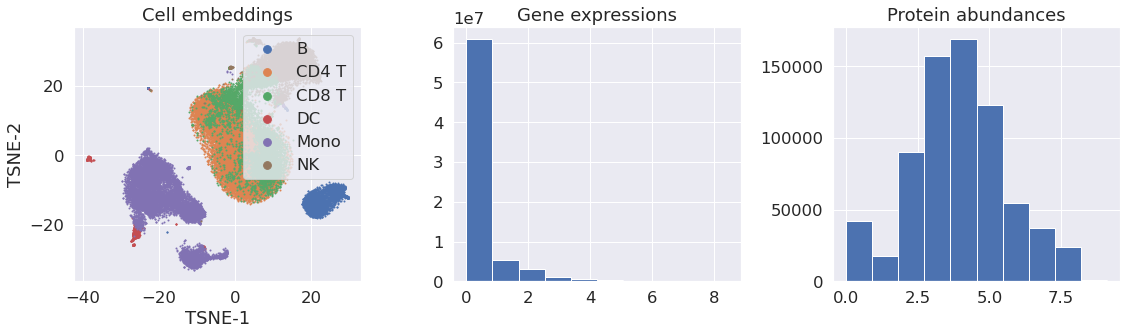

In [29]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X)


fig, axes = plt.subplots(1,3,figsize=(16,5))
for celltype in np.unique(cell_types):
    axes[0].scatter(
        *X_tsne[cell_types==celltype,:].T, s=1, label=celltype)
lgnd = axes[0].legend(loc="upper right")
for j in np.arange(len(np.unique(cell_types))):
    lgnd.legendHandles[j]._sizes = [60]
axes[0].set_xlabel('TSNE-1')
axes[0].set_ylabel('TSNE-2')
axes[0].set_title('Cell embeddings')

axes[1].hist(X[cell_types=='Mono',:].flatten())
axes[1].set_title('Gene expressions')

axes[2].hist(Y[cell_types=='Mono',:].flatten())
axes[2].set_title('Protein abundances')

plt.tight_layout()
plt.savefig(
    'result/fig_sc_overview.pdf', bbox_inches='tight', pad_inches=0, dpi=300,)

## Figure 7, Figure S5

In [30]:
cell_types_list = ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK']
method_list = ['ridge', 'lasso', 'tree'] 
celltype = cell_types_list[3]
method = method_list[2]
cv_method = 'oobcv_250'
path_result = 'result/ex4/{}/{}/'.format(celltype,method)
j = 0
ADT_name = ADT_names[j]
df = pd.read_csv(path_result + 'res_ADT_{}_{}.csv'.format(
    j, cv_method.split('-')[0]), index_col=0)
df = df.sort_values('k_list')


k_hat = df['k_list'].values
res_val = df.loc[:,df.columns.str.startswith('val')].values
res_test = df.loc[:,df.columns.str.startswith('test')].values    

null_risk = np.mean(res_test[:1,:])
res_test /= null_risk
res_val /= null_risk
res_test = res_test[:,:50]
res_val = res_val[:,:50]

df_split = pd.read_csv('df_split.csv', index_col=[0])
n_cell = np.sum((df_split['split']=='train').values & (cell_types==celltype))
n_cell = n_cell*(1-1/np.log(n_cell))

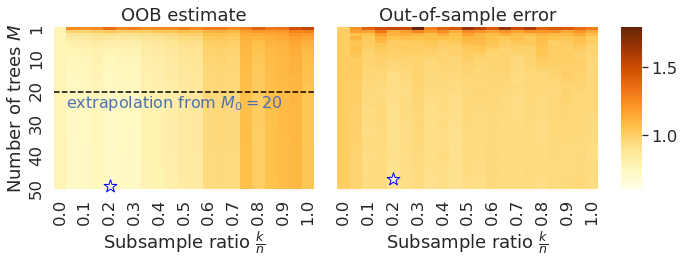

In [31]:

fig, axes = plt.subplots(
    1,3, figsize=(10,4), gridspec_kw={'width_ratios':[1,1,0.08]})
axes[0].get_shared_y_axes().join(axes[1])
sns.heatmap(
    pd.DataFrame(res_val, columns=np.arange(1,51).astype(int), 
                 index=np.round(k_hat/n_cell, 1)).T,
    yticklabels=[str(i) if i%10==0 or i==1 else '' for i in np.arange(1,51)],
    vmin=0.6, vmax=1.8,
    cmap=sns.color_palette("YlOrBr", as_cmap=True), cbar=False,
    ax=axes[0])
opt = np.unravel_index(np.argmin(res_val, axis=None), res_val.shape)
axes[0].scatter([opt[0]+0.5], [opt[1]],  marker='*', s=180, clip_on=False,
           edgecolors='blue', facecolor='white', linewidth=1, zorder=10)

sns.heatmap(
    pd.DataFrame(res_test, columns=np.arange(1,51).astype(int), 
                 index=np.round(k_hat/n_cell, 1)).T,
    vmin=0.6, vmax=1.8,
    cmap=sns.color_palette("YlOrBr", as_cmap=True), cbar_ax=axes[-1],
    ax=axes[1])
opt = np.unravel_index(np.argmin(res_test, axis=None), res_test.shape)
axes[1].scatter([opt[0]+0.5], [opt[1]],  marker='*', s=180, clip_on=False,
           edgecolors='blue', facecolor='lightyellow', linewidth=1, zorder=10)

axes[0].set_ylabel('Number of trees $M$')
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].set_yticklabels([])

for i in range(2):
    axes[i].set_xlabel('Subsample ratio $\\frac{k}{n}$')

axes[0].set_title('OOB estimate')
axes[1].set_title('Out-of-sample error')


for j in range(1):
    xlim = axes[j].get_xlim()
    axes[j].hlines(20, xlim[0], xlim[1], linestyle='--', color='black')
    axes[j].set_xlim(xlim)
    axes[j].text(xlim[0]+1, 25, 'extrapolation from $M_0=20$', color='b', fontsize=16)

plt.tight_layout()
plt.savefig('result/heatmap.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

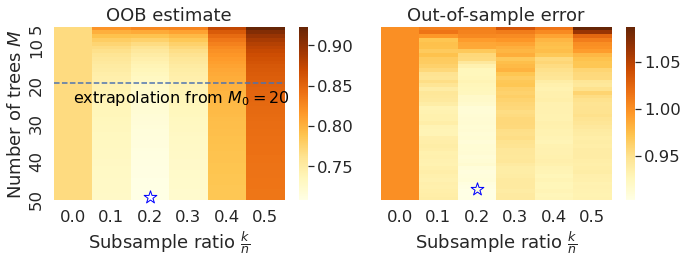

In [32]:
M0 = 5
Mmax = 50
ik = 12
idk = np.arange(0, ik, 2)
_res_val = res_val[idk,M0-1:Mmax]
_res_test = res_test[idk,M0-1:Mmax]
fig, axes = plt.subplots(
    1,2, figsize=(10,4), gridspec_kw={'width_ratios':[1,1]})
sns.heatmap(
    pd.DataFrame(_res_val, columns=np.arange(M0,Mmax+1).astype(int), 
                 index=np.round(k_hat[idk]/n_cell, 1)).T,
    yticklabels=[str(i) if i%10==0 or i==5 else '' for i in np.arange(M0,Mmax+1)],
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
    ax=axes[0])
opt = np.unravel_index(np.argmin(_res_val, axis=None), _res_val.shape)
axes[0].scatter([opt[0]+0.5], [opt[1]],  marker='*', s=180, clip_on=False,
           edgecolors='blue', facecolor='white', linewidth=1, zorder=10)

sns.heatmap(
    pd.DataFrame(_res_test, columns=np.arange(M0,Mmax+1).astype(int), 
                 index=np.round(k_hat[idk]/n_cell, 1)).T,
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
    ax=axes[1])
opt = np.unravel_index(np.argmin(_res_test, axis=None), _res_test.shape)
axes[1].scatter([opt[0]+0.5], [opt[1]],  marker='*', s=180, clip_on=False,
           edgecolors='blue', facecolor='lightyellow', linewidth=1, zorder=10)

axes[0].set_ylabel('Number of trees $M$')
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].set_yticklabels([])

for i in [0,1]:
    axes[i].set_xlabel('Subsample ratio $\\frac{k}{n}$')

axes[0].set_title('OOB estimate')
axes[1].set_title('Out-of-sample error')


for j in range(1):
    xlim = axes[j].get_xlim()
    axes[j].hlines(20-M0, xlim[0], xlim[1], linestyle='--', color='b')
    axes[j].set_xlim(xlim)
    axes[j].text(xlim[0]+0.5, 25-M0, 'extrapolation from $M_0=20$', color='black', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace = 0.1)
plt.savefig('result/heatmap_5.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Figure 8

In [39]:
cell_types_list = ['B', 'DC', 'Mono', 'NK']
method = 'tree'
res_cv_all = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex4/{}/{}/'.format(celltype,method)

    res_cv = []
    cv_method_dict = {
        'splitcv':'splitCV', 
        'kfoldcv':'KfoldCV',
        'oobcv_50':'OOBCV',
        'oobcv_100':'OOBCV-100',
        'oobcv_250':'OOBCV-250'
    }

    for j,ADT_name in enumerate(ADT_names):
        for cv_method in [
            'splitcv', 'kfoldcv', 'oobcv_50', 'oobcv_100', 'oobcv_250']:
            file_name = path_result + 'res_ADT_{}_{}.csv'.format(j, cv_method.split('-')[0])
            df = pd.read_csv(file_name, index_col=0)
            df = df.sort_values('k_list')

                            
            if cv_method=='splitcv':
                k_hat = df['k_list'].values
                null_risk = df.loc[df['k_list']==0,df.columns.str.startswith('test')].mean().mean()
            if cv_method in ['kfoldcv']:
                df.loc[df['k_list']==0,df.columns.str.startswith('test')] = null_risk

            if cv_method.startswith('oobcv') and (not cv_method.endswith('full')):
                df = df[df['k_list'].isin(k_hat)]

            df.loc[:,df.columns.str.startswith('test')] /= null_risk

            for M_max in np.arange(1, 51):
                res_val = df.loc[:,df.columns.str.startswith('val')].values
                if len(cv_method.split('_'))==2 and cv_method!='oobcv_50':
                    pass
                else:
                    res_val[:,M_max:] = np.inf
                res_test = df.loc[:,df.columns.str.startswith('test')].values

                res_cv.append([
                    ADT_name,
                    M_max,
                    cv_method_dict[cv_method], 
                    res_test[np.unravel_index(np.argmin(res_val, axis=None), res_val.shape)]
                ])
    res_cv = pd.DataFrame(res_cv, columns=['ADT_name', 'M_max', 'cv_method', 'NMSE'])
    res_cv['celltype'] = celltype
    res_cv_all = pd.concat([res_cv_all, res_cv], axis=0)

In [40]:
cv_method_dict = {
    'splitcv':'splitCV', 
    'kfoldcv':'KfoldCV',
    'oobcv-50':'OOBCV-50',
    'oobcv-100':'OOBCV-100',
    'oobcv-250':'OOBCV-250',
}
cell_types_list = ['B', 'DC', 'Mono', 'NK']

df = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex4/{}/{}/'.format(celltype,method)

    res_cv = []

    _df = pd.read_csv(path_result+'res_time_{}.csv'.format(method), index_col=0)
    _df = pd.melt(_df, id_vars=['ADT_name'], value_vars=[
        'splitcv', 'oobcv-50','oobcv-100','oobcv-250','kfoldcv',
    ],
           var_name='cv_method', value_name='time')
    _df['cv_method'] = _df['cv_method'].apply(lambda x:cv_method_dict[x])
    _df['celltype'] = celltype
    df = pd.concat([df, _df], axis=0)

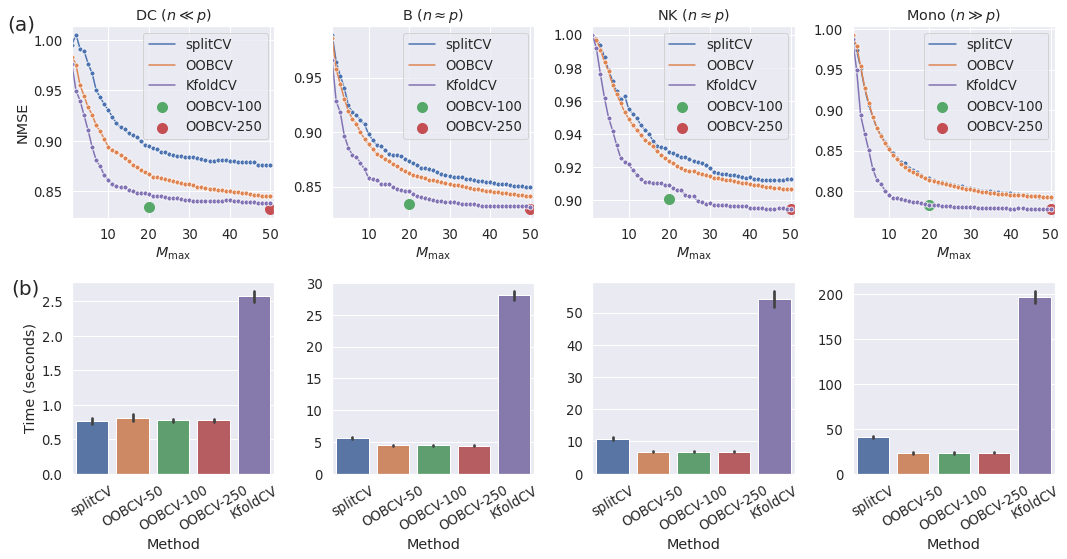

In [41]:

sns.set(font_scale=1.2)

import itertools
fig, axes = plt.subplots(2,4,figsize=(15,8), sharex='row')
cell_types_list = ['DC', 'B', 'NK', 'Mono']
dim_dict = {
    'DC':r'($n\ll p$)', 'B':r'($n\approx p$)', 'NK':r'($n\approx p$)', 'Mono':r'($n\gg p$)'
}
for j in range(4):
    celltype = cell_types_list[j]
    i = 0
    sns.lineplot(
        data=res_cv_all[
            (res_cv_all['celltype']==celltype)&
            (~res_cv_all['cv_method'].isin(['OOBCV-100','OOBCV-250']))
        ], x='M_max', y='NMSE', hue='cv_method', linestyle='-', marker='.', markersize=10,
        estimator='mean', errorbar=None,
        hue_order=['splitCV', 'OOBCV', 'KfoldCV'],
        palette = [sns.color_palette()[k] for k in [0,1,4]],
        ax=axes[i,j]
    )
    for iM,M in enumerate([100,250]):
        axes[i,j].scatter(
            M/5,
            res_cv_all[
                (res_cv_all['celltype']==celltype)&
                (res_cv_all['cv_method'].isin(['OOBCV-{}'.format(M)]))&
                (res_cv_all['M_max']==50)]['NMSE'].mean(),
            marker='o', s=100, color=sns.color_palette()[2+iM], label='OOBCV-{}'.format(M))
    axes[i,j].legend()
    axes[i,j].set_title(celltype + ' ' + dim_dict[celltype])
    axes[0,j].set_xlim([1,51])
    axes[i,j].set_xlabel('$M_{\max}$')
    
    if j!=0:
        axes[i,j].set_ylabel('')
        
    i = 1
    sns.barplot(data=df[df['celltype']==celltype], 
                x='cv_method', y='time', estimator='mean', ax=axes[i,j])
    
    if i==0:
        axes[i,j].set_xlabel('')
    else:
        axes[i,j].set_xlabel('Method')
        axes[i,j].set_xticklabels(
            axes[i,j].get_xticklabels(), rotation=30,
        )
        
    if j==0:
        axes[i,j].set_ylabel('Time (seconds)')
    else:
        axes[i,j].set_ylabel('')
        
axes[0,0].text(-15., 1.01, '(a)', fontsize=20)
axes[1,0].text(-2., 2.6, '(b)', fontsize=20)
plt.tight_layout()
plt.savefig('result/real_data_{}.pdf'.format(method),
            bbox_inches='tight', pad_inches=0, dpi=300,)

# Package information

Package for visualization in this notebook:

In [45]:
print(
    '\n'.join(np.unique([f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)]))
)

h5py==3.1.0
json==2.0.9
matplotlib==3.5.2
numpy==1.24.1
pandas==1.3.3
scipy==1.10.0
seaborn==0.12.1


Package for running the Python scripts:

In [55]:
!conda list -n base -f "python|os|sys|numpy|scipy|pandas|scikit-learn|h5py"


# packages in environment at /home/jinhongd/anaconda3:
#
# Name                    Version                   Build  Channel
blosc                     1.21.0               h8c45485_0  
h5py                      2.10.0           py38h7918eee_0  
nose                      1.3.7           pyhd3eb1b0_1006  
numpy                     1.20.1           py38h93e21f0_0  
numpy-base                1.20.1           py38h7d8b39e_0  
numpydoc                  1.1.0              pyhd3eb1b0_1  
pandas                    1.2.4            py38h2531618_0  
pycosat                   0.6.3            py38h7b6447c_1  
python                    3.8.8                hdb3f193_5  
python-dateutil           2.8.1              pyhd3eb1b0_0  
python-jsonrpc-server     0.4.0                      py_0  
python-language-server    0.36.2             pyhd3eb1b0_0  
python-libarchive-c       2.9                pyhd3eb1b0_1  
python_abi                3.8                      2_cp38    conda-forge
scikit-learn           